<a href="https://colab.research.google.com/github/nedvb/Convolutional-Autoencoder-Image-Upscaler/blob/master/CPSC4430_NedVanBreugel_ML_Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import glob
from PIL import Image
import torchvision
import matplotlib.pyplot as plt

latent_dims = 10
num_epochs = 3
batch_size = 128
capacity = 64
learning_rate = 1e-3
use_gpu = torch.cuda.is_available()

!git clone https://github.com/nedvb/ML-Project-3.git
%cd ML-Project-3/

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        image = Image.open(self.file_list[idx])
        if self.transform:
            image = self.transform(image)
        return image

transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_files = glob.glob('./train_2500/*.jpg')
test_files = glob.glob('./test_2500/*.jpg')
custom_dataset_train = CustomDataset(train_files, transform=transform)
custom_dataset_test = CustomDataset(test_files, transform = transform)

Cloning into 'ML-Project-3'...
remote: Enumerating objects: 5003, done.
remote: Total 5003 (delta 0), reused 0 (delta 0), pack-reused 5003
Receiving objects: 100% (5003/5003), 108.39 MiB | 10.21 MiB/s, done.
Updating files: 100% (5000/5000), done.
/content/ML-Project-3


In [ ]:
train_dataloader = DataLoader(custom_dataset_train, batch_size=64, shuffle=True)
test_dataloader = DataLoader(custom_dataset_test, batch_size=64, shuffle=False)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, capacity=64):
        super(Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=3, stride=1, padding=1)  # 28x28 -> 28x28
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=3, stride=2, padding=1)  # 28x28 -> 14x14
        self.conv3 = nn.Conv2d(in_channels=c*2, out_channels=c*4, kernel_size=3, stride=2, padding=1)  # 14x14 -> 7x7

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        return x

In [ ]:
class Decoder(nn.Module):
    def __init__(self, capacity=64):
        super(Decoder, self).__init__()
        c = capacity
        self.upconv1 = nn.ConvTranspose2d(in_channels=c*4, out_channels=c*2, kernel_size=4, stride=2, padding=1)  # 7x7 -> 14x14
        self.upconv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)  # 14x14 -> 28x28
        self.upconv3 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)  # 28x28 -> 56x56

    def forward(self, x):
        x = F.relu(self.upconv1(x))
        x = F.relu(self.upconv2(x))
        x = torch.sigmoid(self.upconv3(x))
        return x

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder = Autoencoder().to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)
criterion = nn.MSELoss()

num_epochs = 20

for epoch in range(num_epochs):
    for imgs in train_dataloader:
        imgs = imgs.to(device)
        optimizer.zero_grad()
        outputs = autoencoder(imgs)
        resized_imgs = F.interpolate(imgs, size=(56, 56), mode='bilinear', align_corners=False)
        loss = criterion(outputs, resized_imgs)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

print("Training Complete")

Epoch 1, Loss: 0.2485077679157257
Epoch 2, Loss: 0.23080426454544067
Epoch 3, Loss: 0.17278257012367249
Epoch 4, Loss: 0.10845839977264404
Epoch 5, Loss: 0.17378419637680054
Epoch 6, Loss: 0.15180973708629608
Epoch 7, Loss: 0.09829165786504745
Epoch 8, Loss: 0.1165669783949852
Epoch 9, Loss: 0.20036837458610535
Epoch 10, Loss: 0.16730499267578125
Epoch 11, Loss: 0.11901457607746124
Epoch 12, Loss: 0.14179393649101257
Epoch 13, Loss: 0.0714932456612587
Epoch 14, Loss: 0.150368794798851
Epoch 15, Loss: 0.2044585645198822
Epoch 16, Loss: 0.1245710626244545
Epoch 17, Loss: 0.1303676962852478
Epoch 18, Loss: 0.046893101185560226
Epoch 19, Loss: 0.1026458814740181
Epoch 20, Loss: 0.0944034531712532
Training Complete


Original Images


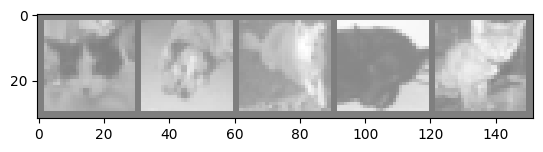

Reconstructed Images


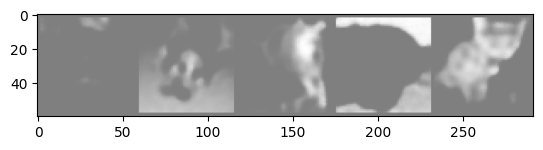

In [ ]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(test_dataloader)
images = next(dataiter)
images = images.to(device)
recon_images = autoencoder(images)

print("Original Images")
imshow(torchvision.utils.make_grid(images.cpu().data[:5], normalize=True))

print("Reconstructed Images")
imshow(torchvision.utils.make_grid(recon_images.cpu().data[:5], normalize=True))